# Volatility, Risk, and The Sharpe Ratio

###In this lecture, we investigate the role of volatility for computing risk and measuring risk-return tradeoffs. We study how volatility and expected returns depend on the horizon, and using this dependence to introduce **annualization**, a key practical concept in finance.


In [ ]:
# Import necessary libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
data = yf.download('SPY', period='max')

# Display the first few rows
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,24.608610,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,24.783646,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,24.836153,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,25.098694,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,25.203720,531500


## Understanding Returns

#We have prices $P_t$ (adjusted for dividends), so that Close-to-Close returns can be computed as
$$
R_{t+1}\ =\ P_{t+1} / P_t - 1\ =\ pct\_change(close\ prices)
$$
#When we deal with returns over longer horizons, we need to be more careful. For example, we can define Monthly returns as  
$$
R^M_{t+25}\ \approx\ P_{t+25} / P_t\ -\ 1
$$
#but the exact calculation requires knowing dates of the month. It is instructive to represent longer-term returns as products of shorter-term returns,
$$
\frac{P_{t+25}}{P_t}\ =\ \frac{P_{t+1}}{P_t}\frac{P_{t+2}}{P_{t+1}}\cdots \frac{P_{t+1}}{P_t},
$$
#which can be rewritten as
$$
1+R^M_{t+25}\ =\ (1+R_{t+1})(1+R_{t+2})\cdots (1+R_{t+25})\,.
$$
#Equivalently, we can apply $\log$ and get
$$
\log(1+R^M_{t+25})\ =\ \log(1+R_{t+1})\ +\ \log(1+R_{t+2})\ +\ \cdots\  \log(1+R_{t+25})\,.
$$
# If returns are small, we know that
$$
\log(1+R)\approx\ R
$$
#when $R$ is small. Thus,
$$
\log(1+R^M_{t+25})\ =\ \log(1+R_{t+1})\ +\ \log(1+R_{t+2})\ +\ \cdots\  \log(1+R_{t+25})\ \approx\ R_{t+1}+\cdots+R_{t+25}
$$
# Note also that if $R^M_{t+25}$ is small, then
$$
\log(1+R^M_{t+25})\ \approx\ R^M_{t+25}
$$

In [ ]:
import numpy as np
np.log(1+0.2)

0.1823215567939546

In [ ]:
## Calculating Daily Returns
close_prices = data['Adj Close']
daily_returns = close_prices.pct_change()
manual_dailyreturns = close_prices / close_prices.shift(1) - 1
pd.concat([daily_returns, manual_dailyreturns], axis=1).head()

,Adj Close,Adj Close
Date,,
1993-01-29,NaN,NaN
1993-02-01,0.007113,0.007113
1993-02-02,0.002119,0.002119
1993-02-03,0.010571,0.010571
1993-02-04,0.004185,0.004185


In [ ]:
## Calculating Monthly Returns
monthly_returns_additive = daily_returns.resample('ME').sum()
monthly_returns_multiplicative = (daily_returns + 1).resample('ME').prod() - 1
monthly_returns_multiplicative2 = close_prices.resample('ME').last().pct_change()
concatenated_stuff = pd.concat([monthly_returns_additive, monthly_returns_multiplicative, monthly_returns_multiplicative2], axis=1)
concatenated_stuff.columns = ['additive', 'multiplicative', 'multiplicative2']
concatenated_stuff.head()


,additive,multiplicative,multiplicative2
Date,,,
1993-01-31,0.000000,0.000000,NaN
1993-02-28,0.011194,0.010669,0.010669
1993-03-31,0.022721,0.022399,0.022399
1993-04-30,-0.025358,-0.025588,-0.025588
1993-05-31,0.027100,0.026969,0.026969


# Key characteristics of returns are means and standard deviations
$$
E[R]\ =\ \frac1T \sum_t R_t
$$
# and
$$
STD(R)\ =\ \left(\frac1T \sum_t R_t^2-E[R]^2\right)^{1/2}
$$
# The reason is that they tell us, roughly the **confidence band for returns**:
$$
R_t\in [E[R]-2\cdot STD(R),\ E[R]+2\cdot STD(R)]
$$

In [ ]:
leverage = 1.
(leverage * daily_returns).mean(), (leverage * daily_returns).std()

(0.0009258381183904495, 0.02349216676241391)

$$
num\_shares * close\_prices = leverage * wealth
$$
# so that
$$
num\_shares\ =\ \frac{leverage * wealth}{close\_prices}
$$

<Axes: xlabel='Date'>

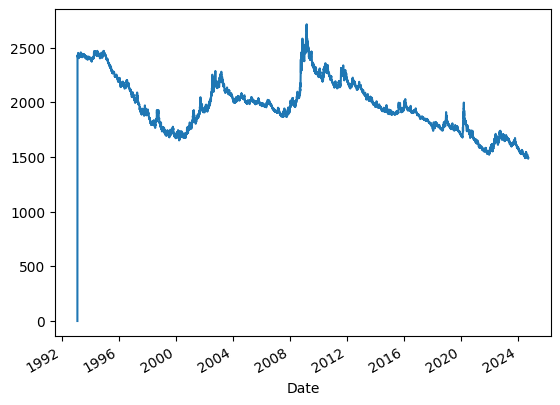

In [ ]:
r_f = 0.05 / 252
leverage = 0.6
true_returns = r_f + leverage * (daily_returns - r_f)
true_returns.mean(), true_returns.std()
wealth_0 = 10 ** 5
wealth = wealth_0 * (1 + true_returns).cumprod()
#wealth.plot()

num_shares = ((leverage * wealth) / close_prices).fillna(0).replace(np.inf, 0).astype(int)
num_shares.plot()



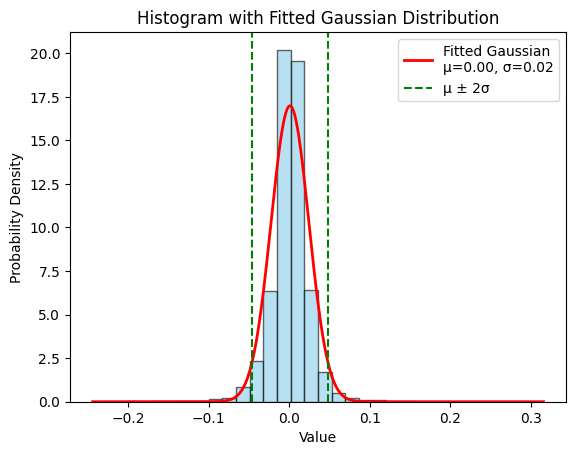

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Replace this sample data with your actual data
# For example: data = your_data_array
data = 2 * daily_returns.dropna()

# Plot the histogram of the data
count, bins, ignored = plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Fit a Gaussian distribution to the data
mu, sigma = norm.fit(data)

# Create a range of values for the fitted curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu, sigma)

# Plot the fitted Gaussian curve
plt.plot(x, p, 'r', linewidth=2, label=f'Fitted Gaussian\nμ={mu:.2f}, σ={sigma:.2f}')

# Add vertical lines at μ ± 2σ
plt.axvline(mu - 2*sigma, color='green', linestyle='dashed', linewidth=1.5, label='μ ± 2σ')
plt.axvline(mu + 2*sigma, color='green', linestyle='dashed', linewidth=1.5)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Histogram with Fitted Gaussian Distribution')

# Add a legend
plt.legend()

# Show the plot
plt.show()


# We usually measure the quality of returns using the Sharpe Ratio, named after [Bill Sharpe](https://en.wikipedia.org/wiki/William_F._Sharpe),
$$
SR(R)\ =\ \frac{E[R]}{STD(R)}
$$
# However, investors would often like to know the performance of your strategy over an annual horizon. Hence, we would like to know $E[R^A]$ and $STD(R^A).$ The problem is that estimating these is very tricky as we do not have enough data! Instead, we use the math trick: Given 252 business days in a year
$$
E[R^A]\ =\ E[R_1+\cdots+R_{252}]\ \approx\ 252\cdot E[R]
$$
#while
$$
Var[R^A]\ = E[(R^A)^2]-E[R^A]^2 \approx\ E[(R^A)^2]\ \approx\ E[R_1^2+\cdots+R_{252}^2]\ \approx\ 252 E[R_1^2]\ \approx\ 252 Var[R_1]
$$
#Thus,
$$
STD(R^A)\ \approx\ \sqrt{252} STD(R_1)
$$
# Annualized Sharpe Ratio is then
$$
\frac{E[R^A]}{STD(R^A)}\ \approx\ \frac{252\cdot E[R]}{\sqrt{252} STD(R_1)}\ =\ \sqrt{252}\frac{E[R]}{ STD(R_1)}
$$

<Axes: xlabel='Date'>

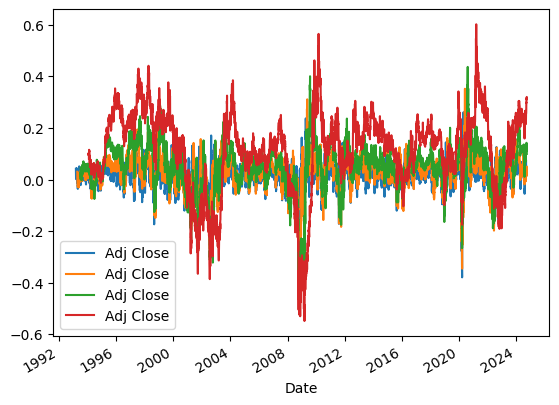

In [ ]:
# Let us check this beautiful math.
windows = [25, 50, 100, 250]
rolling_rets = pd.concat([daily_returns.rolling(w).sum() for w in windows], axis=1)
rolling_rets.plot()

In [ ]:
mean_stds = rolling_rets.std().values
print(mean_stds)
daily_std = daily_returns.std()
approximate_stds = np.sqrt(np.array(windows)) * daily_std

[0.0489772  0.06585932 0.09152908 0.15583636]


In [ ]:
approximate_stds

array([0.05873042, 0.08305735, 0.11746083, 0.18572189])

In [ ]:
def annualized_sharpe_ratio(daily_returns):
    return np.sqrt(252) * daily_returns.mean() / daily_returns.std()



In [ ]:
leverage = np.arange(0.01, 5, 0.01)
sharpes = pd.DataFrame(index=leverage, columns=['SR'])
r_f = 0.05 / 252
for lev in leverage:
  true_returns = r_f + lev * (daily_returns - r_f)
  log_rets = np.log(1 + true_returns)
  sr = log_rets.loc[:'2010-01-01'].mean()
  sharpes.loc[lev, 'SR'] = sr

<Axes: >

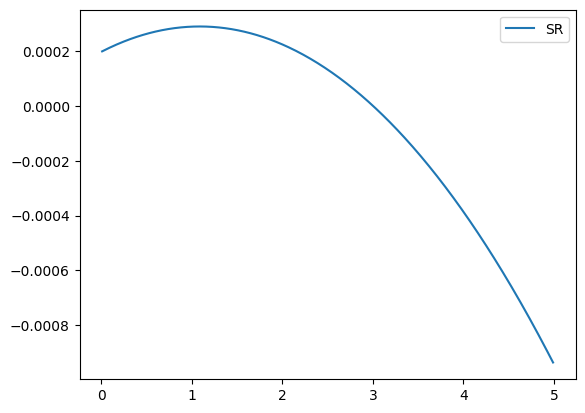

In [ ]:
sharpes.plot()

In [ ]:
lev=0.6
r_f = 0.
true_returns = r_f + lev * (daily_returns - r_f)
log_rets = np.log(1 + true_returns)
sr = annualized_sharpe_ratio(log_rets)

0.5694499012505011

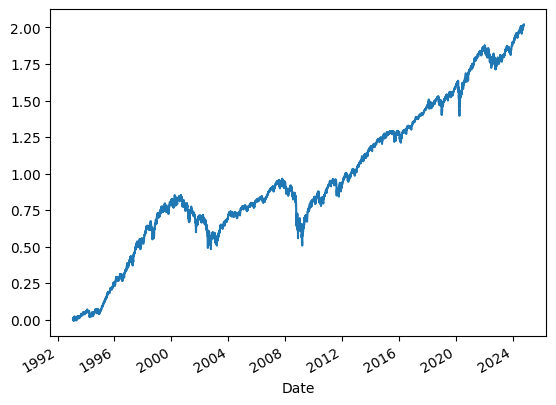

In [ ]:
log_rets.cumsum().plot(); log_rets.mean() / log_rets.std() * np.sqrt(252)